<span style="color: #98FB98;">This dataset is originally from the N. Inst. of Diabetes & Diges. & Kidney Dis.</span>

About Dataset Context This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective is to predict based on diagnostic measurements whether a patient has diabetes.

Content Several constraints were placed on the selection of these instances from a larger database. <span style="color: #98FB98;">In particular, all patients here are females at least 21 years old of Pima Indian heritage.



In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE

# Model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix,make_scorer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

# XGBoost
import xgboost as xgb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects

# SHAP (explainability)
import shap

# imbalanced-learn pipeline
from imblearn.pipeline import Pipeline

# Pydantic
from pydantic import BaseModel, Field
from typing import List, Dict, Any

In [2]:
data = pd.read_csv('diabetes.csv')
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


- Pregnancies: Number of times pregnant 

- Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test 

- BloodPressure: Diastolic blood pressure (mm Hg) 

- SkinThickness: Triceps skin fold thickness (mm) 

- Insulin: 2-Hour serum insulin (mu U/ml) 

- BMI: Body mass index (weight in kg/(height in m)^2) 

- DiabetesPedigreeFunction: Diabetes pedigree function 

- Age: Age (years) 

- Outcome: Class variable (0 or 1) 

In [3]:
data.shape

(768, 9)

In [4]:
data["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

This confirms a moderate class imbalance (roughly 2:1). While not extreme, it’s worth considering techniques like class weighting or oversampling

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


<span style="color: #D32F2F;">there are wrong values : 
1. Glucose cant be zero 
2. Blood Pressure cant be zero 
3. Skin thickness cant be zero 
4. BMI cant be zero 

<span style="color: #FFCCCB;"> insulin is trickier; zero is rare but possible in extreme cases, so we’ll investigate it too

In [7]:
# lets explore the zeros 
data[data[["BMI","Glucose","BloodPressure","SkinThickness","Insulin"]].eq(0).any(axis=1)]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
5,5,116,74,0,0,25.6,0.201,30,0
7,10,115,0,0,0,35.3,0.134,29,0
...,...,...,...,...,...,...,...,...,...
761,9,170,74,31,0,44.0,0.403,43,1
762,9,89,62,0,0,22.5,0.142,33,0
764,2,122,70,27,0,36.8,0.340,27,0
766,1,126,60,0,0,30.1,0.349,47,1


In [8]:
data[data["Insulin"]==0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
5,5,116,74,0,0,25.6,0.201,30,0
7,10,115,0,0,0,35.3,0.134,29,0
...,...,...,...,...,...,...,...,...,...
761,9,170,74,31,0,44.0,0.403,43,1
762,9,89,62,0,0,22.5,0.142,33,0
764,2,122,70,27,0,36.8,0.340,27,0
766,1,126,60,0,0,30.1,0.349,47,1


In [9]:
zeros= (data[["BMI","Glucose","BloodPressure","SkinThickness","Insulin"]]==0).sum()
zeros

BMI               11
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
dtype: int64

- Glucose: ~5 zeros

- BloodPressure: ~35 zeros

- SkinThickness: ~227 zeros

- Insulin: ~374 zeros

- BMI: ~11 zeros

<span style="color: #FFCCCB;">These numbers suggest a significant issue, especially with SkinThickness and Insulin, where nearly 30-50% of the data is zero.

<span style="color: #98FB98;"> SO WHATS THE POSSIBLE OPTIONS WE HAVE ? 

- Drop Rows: Remove rows with zeros in critical features (Glucose, BMI). This works if the number of affected rows is small, but with SkinThickness and Insulin, we’d lose too much data so nah 


- Imputation: Replace zeros with a reasonable value:
    - Mean/Median: Simple and preserves data size, but assumes zeros are missing at random.
    - KNN Imputation: Uses nearest neighbors to estimate values based on similar patients—more sophisticated and potentially more accurate.


- Domain-Specific Imputation: Use clinical norms (typical BloodPressure ~80 mm Hg), though this risks introducing bias.


- Treat as Missing: Some models (e.g., XGBoost) can handle missing values natively if we mark zeros as NaN.

Glucose, BloodPressure, BMI: These are critical diagnostic features with fewer zeros (5-35 rows). <span style="color: #98FB98;">I will Impute with the median (robust to outliers) calculated from non-zero values within each Outcome class (0 or 1 separately) to preserve class-specific patterns.

SkinThickness, Insulin: Too many zeros (227 and 374). Imputing such a large portion risks distorting the data. <span style="color: #98FB98;">So we may:
- Impute with median for now, but experiment with treating them as missing (NaN) later if using a model like XGBoost.
- drop these features entirely if they don’t add predictive power after testing.

In [11]:
features_to_fix = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Replace zeros with class-specific medians
for feature in features_to_fix:
    for outcome in [0, 1]:
        # Get non-zero values for this feature and outcome
        mask = (data[feature] > 0) & (data["Outcome"] == outcome)
        #this code will slecet the rows where the mask condition is true.
        median_value = data.loc[mask, feature].median()
        # Replace zeros for this outcome
        data.loc[(data[feature] == 0) & (data["Outcome"] == outcome), feature] = median_value




In [10]:

 # write it as function 
def replace_zeros_with_class_median(data, features, target_col="Outcome"):
    """
        this function will replace the zeros with class(0,1) median 
        pass the folowing :
            - data (pd.DataFrame): The dataset containing the features + target column
            - features (list): List of feature to fix 
            - target_col (str): The target column used to group data (default is 'Outcome').

         Returns: The modified dataset with zeros replaced by class-specific medians :)
    """
    for feature in features:
        for outcome in data[target_col].unique(): # or in [0,1]
            mask = (data[feature] > 0) & (data[target_col] == outcome)
            #this code will slecet the rows where the mask condition is true.
            median_value = data.loc[mask, feature].median()
                
            # Replace zeros with the  median
            data.loc[(data[feature] == 0) & (data[target_col] == outcome), feature] = median_value

    return data

In [11]:
zeros= (data[["BMI","Glucose","BloodPressure","SkinThickness","Insulin"]]==0).sum()
zeros

BMI               11
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
dtype: int64

In [12]:
features_to_fix = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

replace_zeros_with_class_median(data,features_to_fix)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72.0,35,169.5,33.6,0.627,50,1
1,1,85,66.0,29,102.5,26.6,0.351,31,0
2,8,183,64.0,32,169.5,23.3,0.672,32,1
3,1,89,66.0,23,94.0,28.1,0.167,21,0
4,0,137,40.0,35,168.0,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76.0,48,180.0,32.9,0.171,63,0
764,2,122,70.0,27,102.5,36.8,0.340,27,0
765,5,121,72.0,23,112.0,26.2,0.245,30,0
766,1,126,60.0,32,169.5,30.1,0.349,47,1


In [13]:
zeros= (data[["BMI","Glucose","BloodPressure","SkinThickness","Insulin"]]==0).sum()
zeros

BMI              0
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
dtype: int64

the following code is from the previous notebok

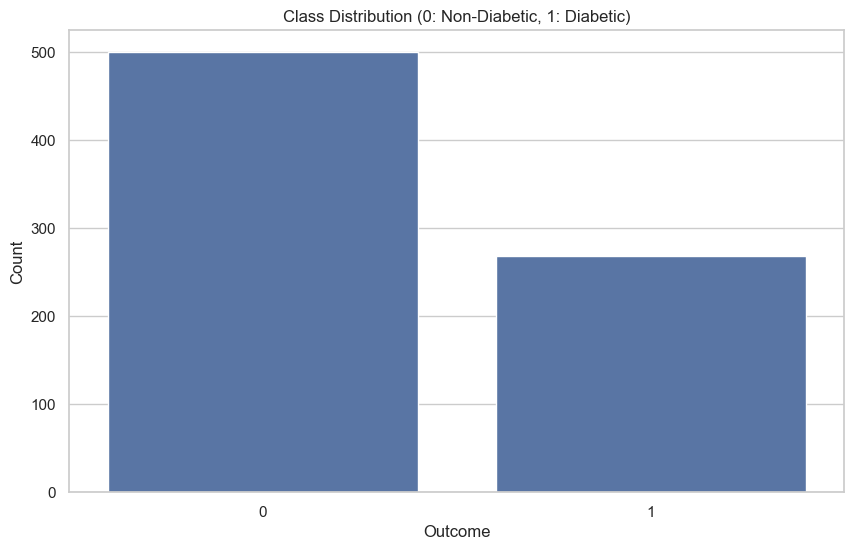

Class Balance:
0    0.651042
1    0.348958
Name: Outcome, dtype: float64


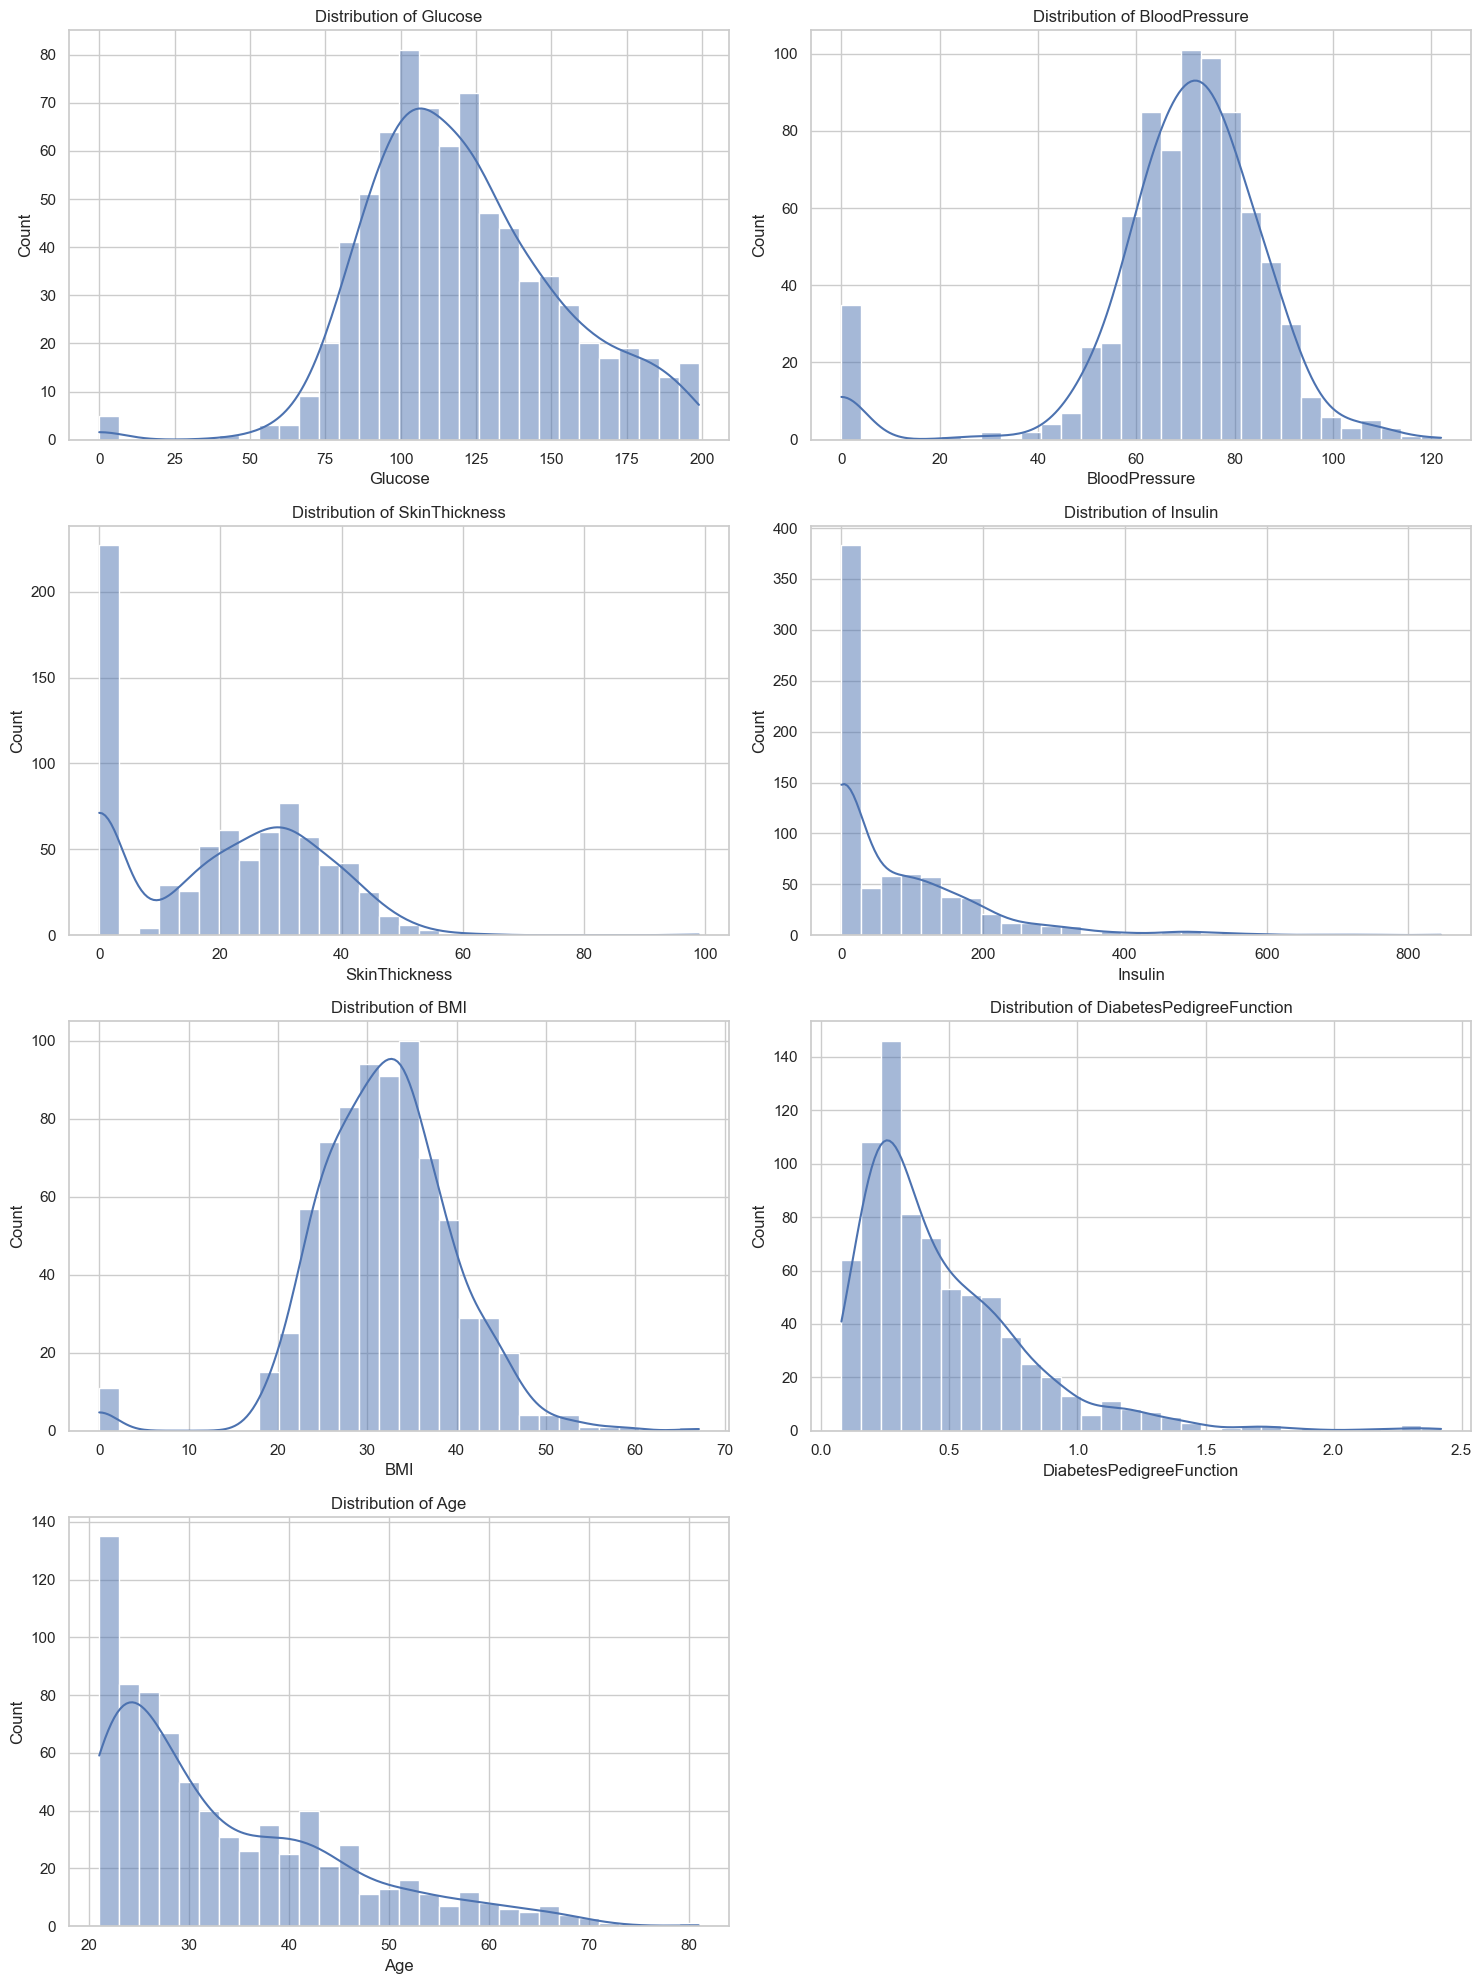

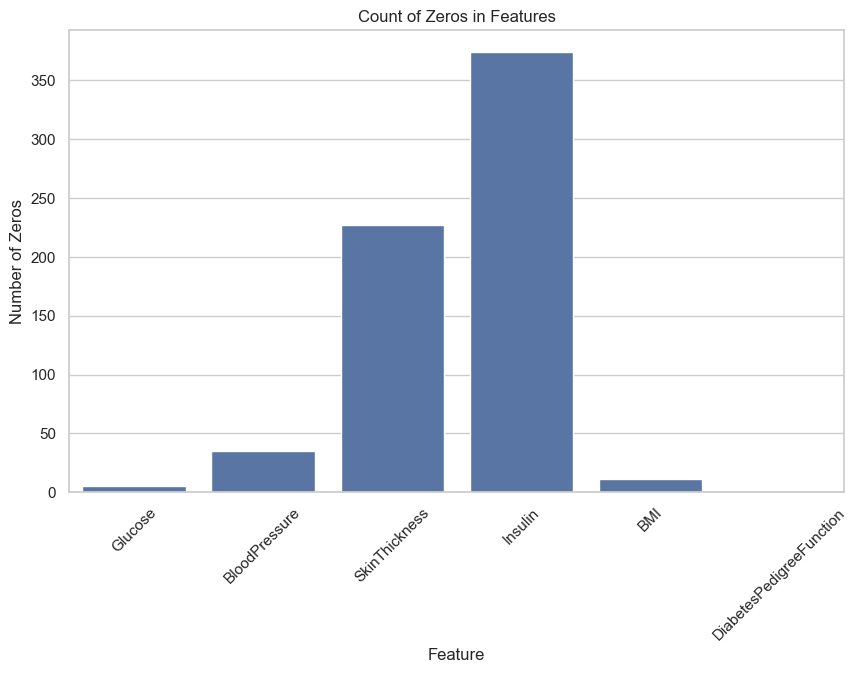

Zero Counts:
{'Glucose': 5, 'BloodPressure': 35, 'SkinThickness': 227, 'Insulin': 374, 'BMI': 11, 'DiabetesPedigreeFunction': 0}


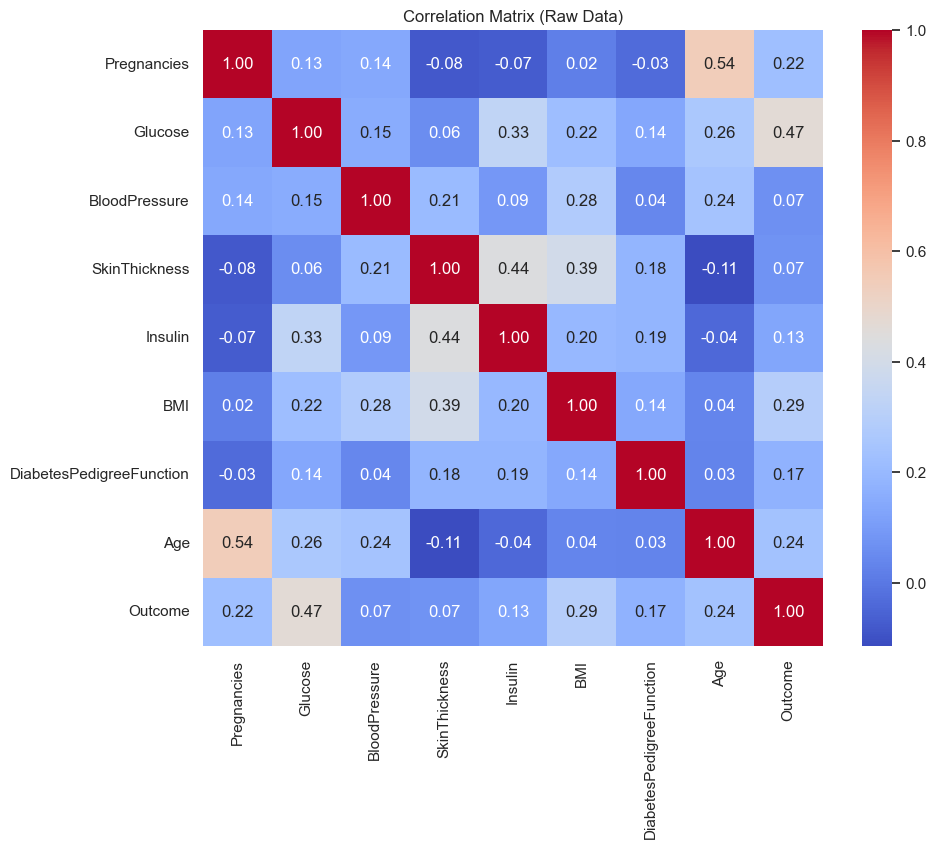

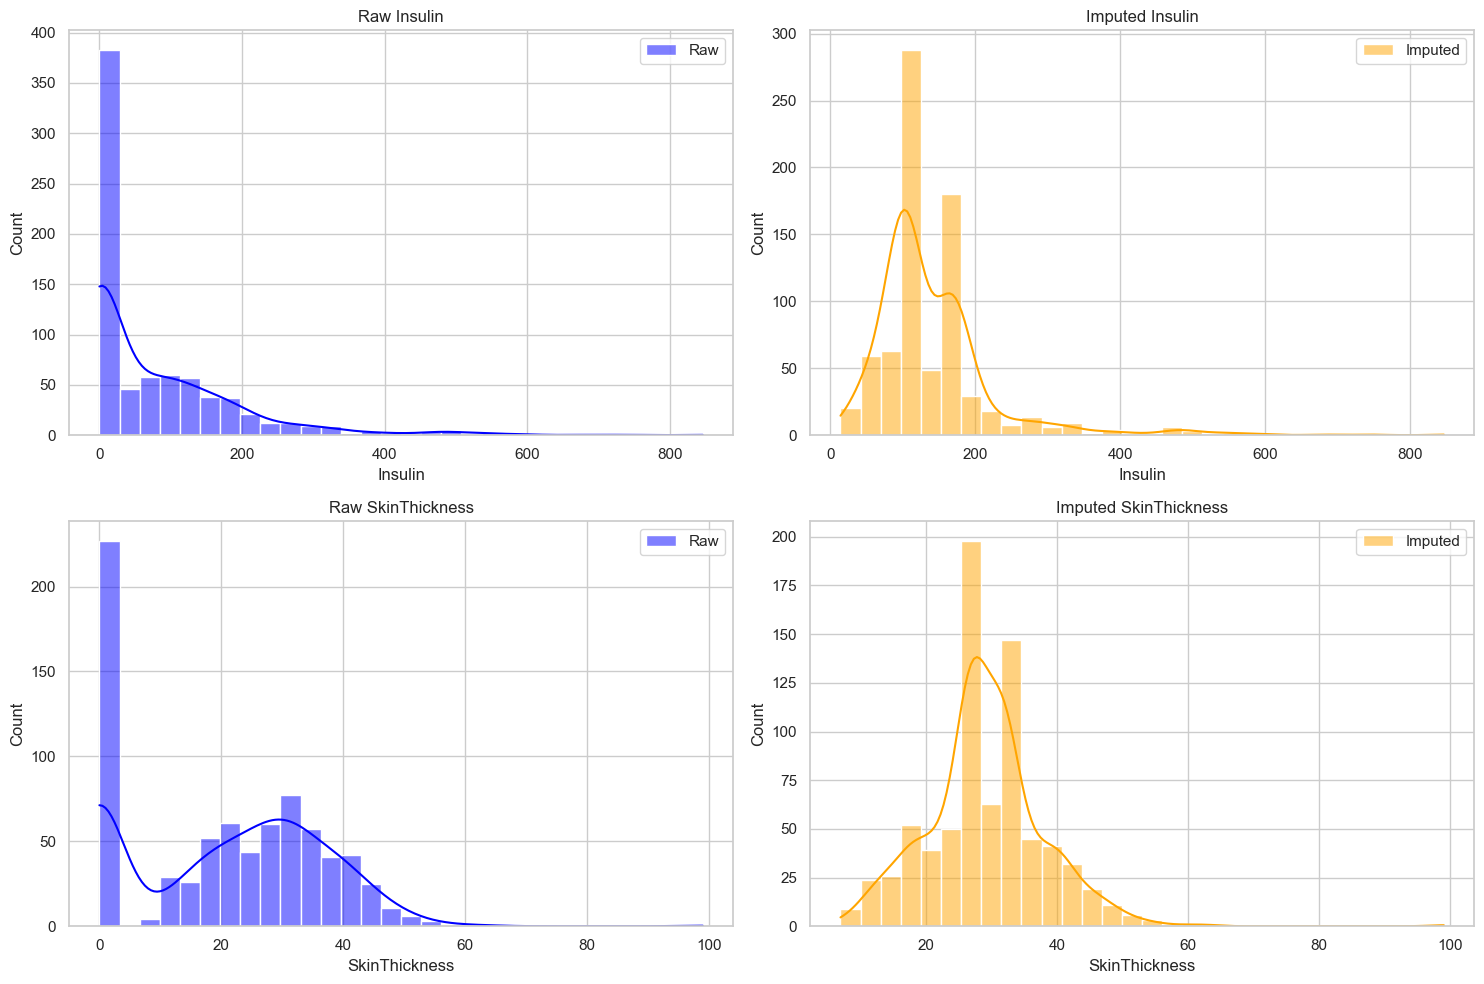

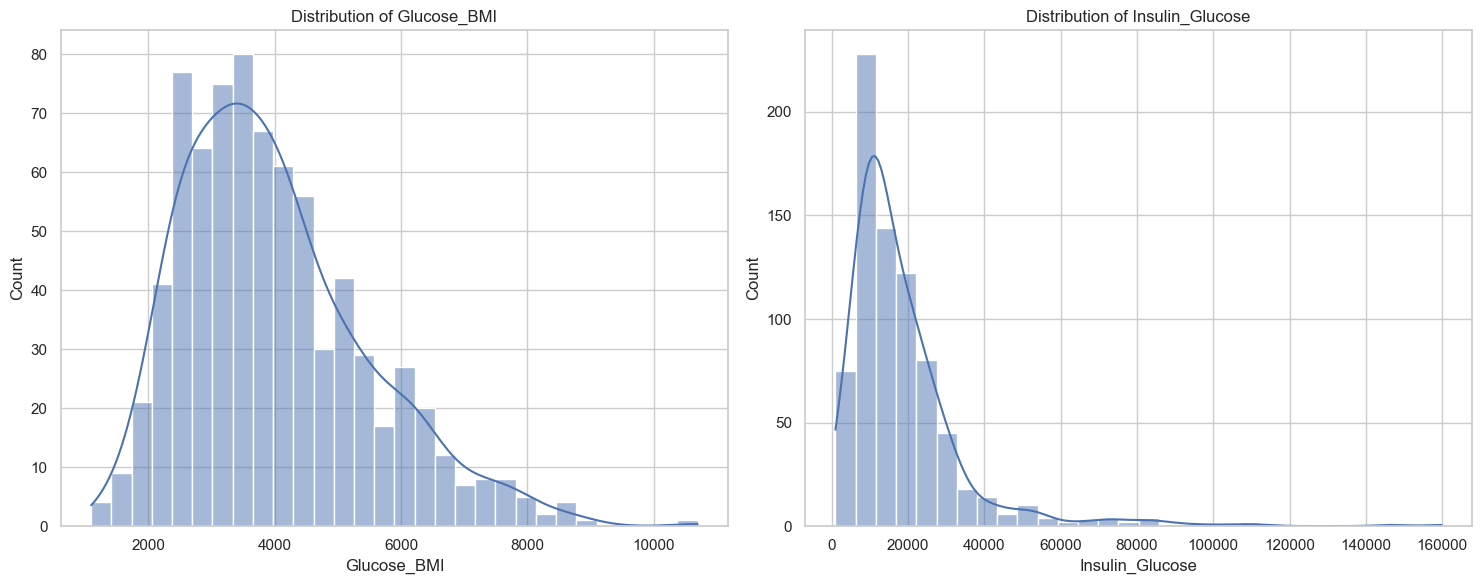

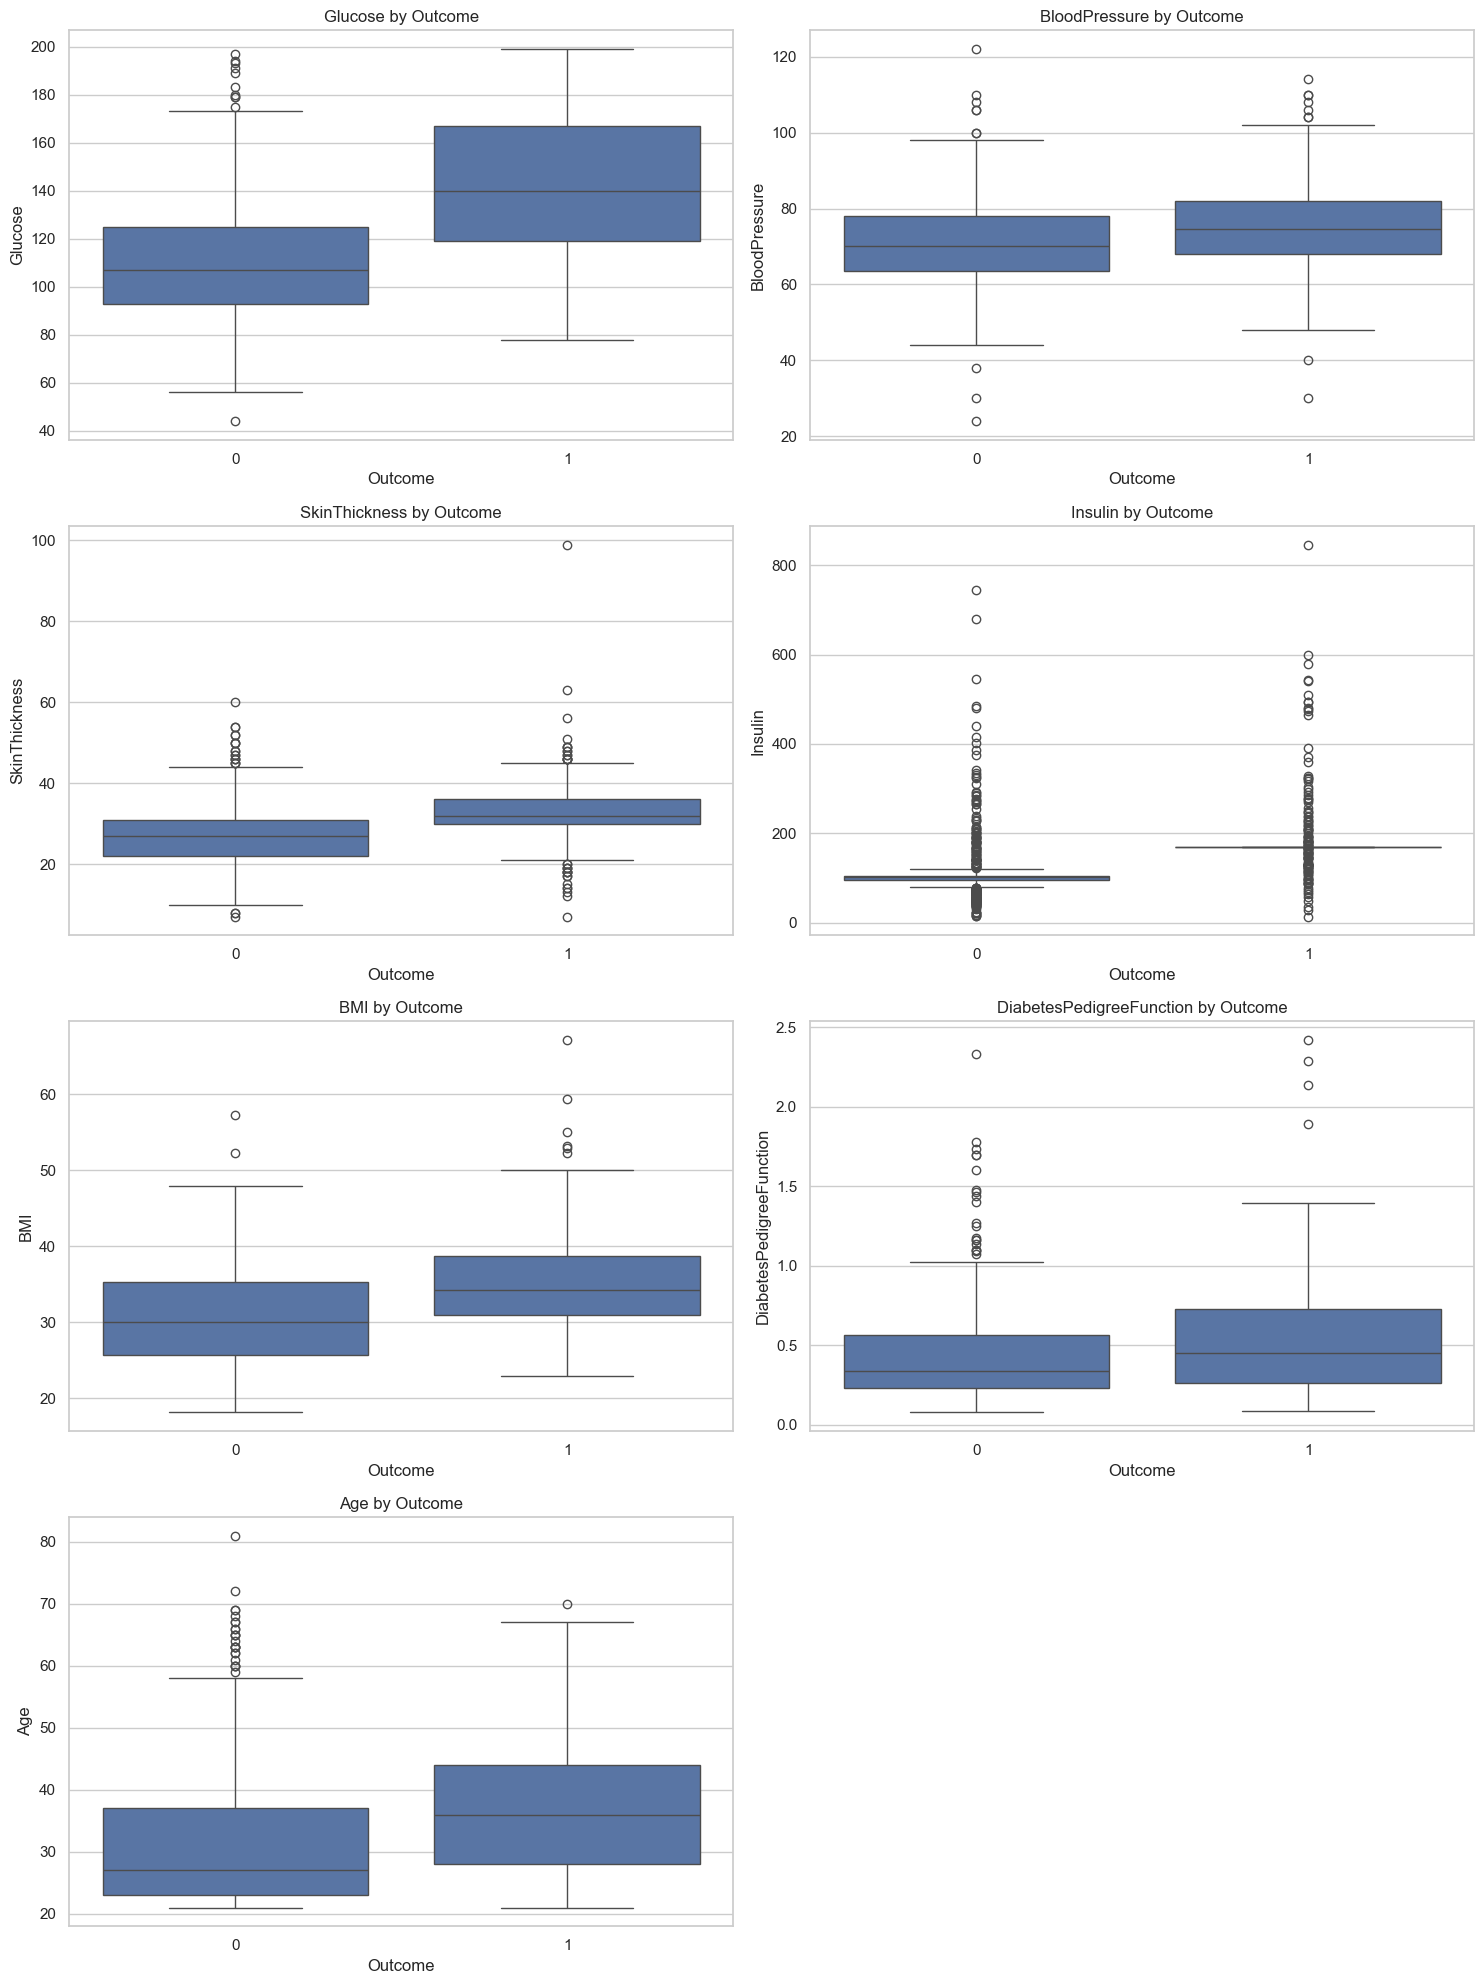

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data=pd.read_csv("diabetes.csv")
# Set style for better visuals
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# 1. Class Balance
plt.figure()
sns.countplot(x="Outcome", data=data)
plt.title("Class Distribution (0: Non-Diabetic, 1: Diabetic)")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.show()
print(f"Class Balance:\n{data['Outcome'].value_counts(normalize=True)}")

# 2. Distributions of Raw Features
features = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.ravel()
for i, feature in enumerate(features):
    sns.histplot(data[feature], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Count")
axes[-1].axis("off")  # Hide extra subplot
plt.tight_layout()
plt.show()

# 3. Zero Counts
zero_counts = {feature: (data[feature] == 0).sum() for feature in features if feature != "Age"}
plt.figure()
sns.barplot(x=list(zero_counts.keys()), y=list(zero_counts.values()))
plt.title("Count of Zeros in Features")
plt.xlabel("Feature")
plt.ylabel("Number of Zeros")
plt.xticks(rotation=45)
plt.show()
print(f"Zero Counts:\n{zero_counts}")

# 4. Correlations (Raw Data)
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (Raw Data)")
plt.show()

# 5. Pre/Post-Imputation Comparison (Median)
data_imputed = data.copy()
features_to_fix = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for feature in features_to_fix:
    for outcome in [0, 1]:
        mask = (data_imputed[feature] > 0) & (data_imputed["Outcome"] == outcome)
        median_value = data_imputed.loc[mask, feature].median()
        data_imputed.loc[(data_imputed[feature] == 0) & (data_imputed["Outcome"] == outcome), feature] = median_value

# Add engineered features
data_imputed["Glucose_BMI"] = data_imputed["Glucose"] * data_imputed["BMI"]
data_imputed["Insulin_Glucose"] = data_imputed["Insulin"] * data_imputed["Glucose"]

# Plot pre/post for key features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()
for i, feature in enumerate(["Insulin", "SkinThickness"]):
    # Raw
    sns.histplot(data[feature], bins=30, kde=True, ax=axes[i*2], color="blue", alpha=0.5, label="Raw")
    axes[i*2].set_title(f"Raw {feature}")
    # Imputed
    sns.histplot(data_imputed[feature], bins=30, kde=True, ax=axes[i*2+1], color="orange", alpha=0.5, label="Imputed")
    axes[i*2+1].set_title(f"Imputed {feature}")
    for ax in axes[i*2:i*2+2]:
        ax.legend()
        ax.set_xlabel(feature)
        ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

# 6. Engineered Features Distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(data_imputed["Glucose_BMI"], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Distribution of Glucose_BMI")
sns.histplot(data_imputed["Insulin_Glucose"], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Distribution of Insulin_Glucose")
plt.tight_layout()
plt.show()

# 7. Boxplot by Outcome (Imputed Data)
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.ravel()
features_imputed = features + ["Glucose_BMI", "Insulin_Glucose"]
for i, feature in enumerate(features_imputed[:7]):  # Limit to 7 for layout
    sns.boxplot(x="Outcome", y=feature, data=data_imputed, ax=axes[i])
    axes[i].set_title(f"{feature} by Outcome")
axes[-1].axis("off")
plt.tight_layout()
plt.show()

## <span style="color: #98FB98;"> Random Forest 


In [15]:
data = replace_zeros_with_class_median(data,features_to_fix)
X = data.drop("Outcome", axis=1)
y = data["Outcome"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

rf_model_I = RandomForestClassifier(n_estimators=100, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1_score": make_scorer(f1_score)
}

cv_results = cross_validate(rf_model_I, X_scaled, y, cv=5, scoring=scoring)

mean_accuracy = np.mean(cv_results["test_accuracy"])
mean_precision = np.mean(cv_results["test_precision"])
mean_recall = np.mean(cv_results["test_recall"])
mean_f1 = np.mean(cv_results["test_f1_score"])


print(f"5-Fold Cross-Validation Results:")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean F1 Score: {mean_f1:.4f}")




5-Fold Cross-Validation Results:
Mean Accuracy: 0.8776
Mean Precision: 0.8435
Mean Recall: 0.7987
Mean F1 Score: 0.8200


Feature Importance Scores (Random Forest):
Insulin: 0.3610
Glucose: 0.1584
SkinThickness: 0.1434
BMI: 0.0877
Age: 0.0864
DiabetesPedigreeFunction: 0.0650
BloodPressure: 0.0505
Pregnancies: 0.0477


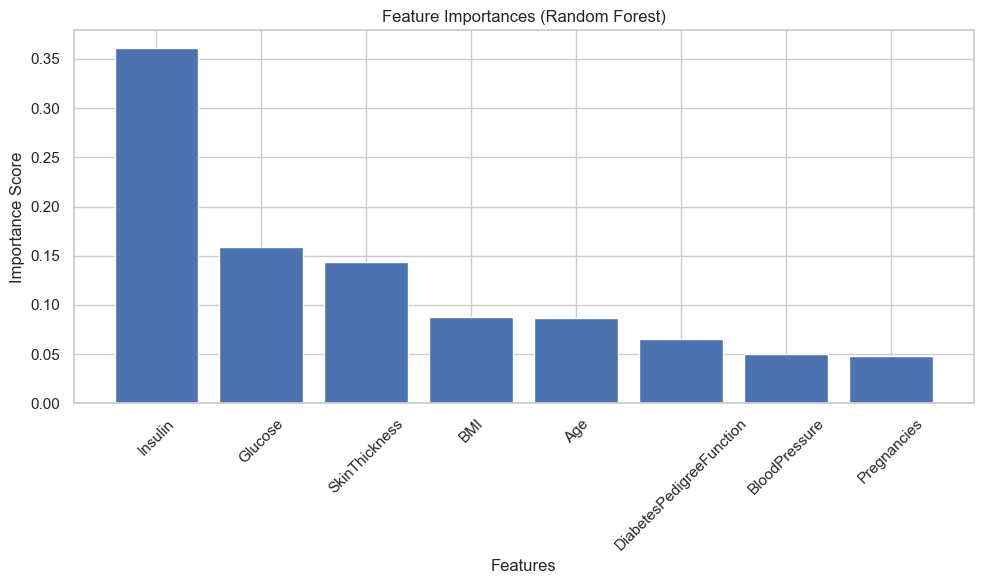

<Figure size 1000x600 with 0 Axes>

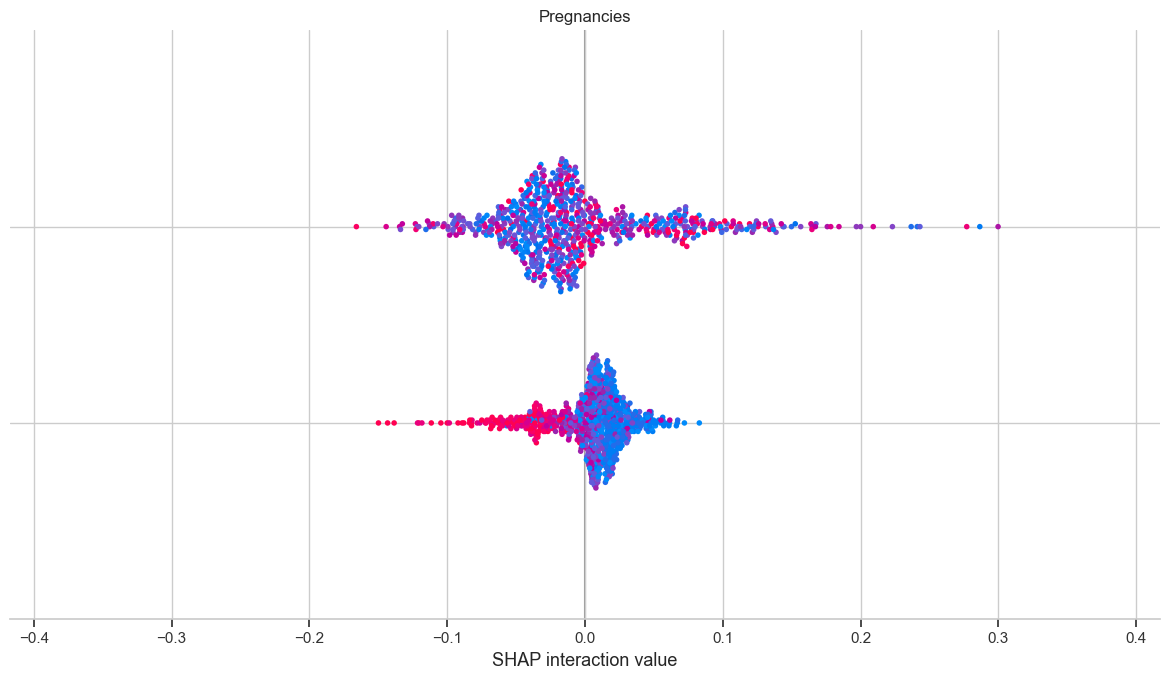

In [16]:
# --- Feature Importance Scores ---
rf_model_I.fit(X_scaled, y)  
feature_names = X.columns
importances = rf_model_I.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature Importance Scores (Random Forest):")
for i in indices:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

# --- SHAP Analysis ---
explainer = shap.TreeExplainer(rf_model_I)
shap_values = explainer.shap_values(X_scaled)
shap.summary_plot(shap_values, X_scaled, feature_names=feature_names)

<span style="color: #98FB98;">  Finding the best parameters + adding class weights



In [28]:
data = pd.read_csv("diabetes.csv")
data = replace_zeros_with_class_median(data,features_to_fix)
X = data.drop("Outcome", axis=1)
y = data["Outcome"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Define the Random Forest with class weights
rf_model_weighted  = RandomForestClassifier(random_state=42, class_weight="balanced")

# Updated parameter grid 
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
    "max_features": ["sqrt", "log2"]  
}

grid_search = GridSearchCV(
    estimator=rf_model_weighted,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid_search.fit(X_scaled, y)

best_rf_weighted = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

scoring = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1_score": make_scorer(f1_score)

}
cv_results = cross_validate(best_rf_weighted, X_scaled, y, cv=5, scoring=scoring)

mean_accuracy = np.mean(cv_results["test_accuracy"])
mean_precision = np.mean(cv_results["test_precision"])
mean_recall = np.mean(cv_results["test_recall"])
mean_f1 = np.mean(cv_results["test_f1_score"])


print(f"5-Fold Cross-Validation Results (Tuned Model):")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean F1 Score: {mean_f1:.4f}")

Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
5-Fold Cross-Validation Results (Tuned Model):
Mean Accuracy: 0.8829
Mean Precision: 0.8514
Mean Recall: 0.8063
Mean F1 Score: 0.8281


Feature Importance Scores (Random Forest):
Insulin: 0.3645
Glucose: 0.1595
SkinThickness: 0.1476
BMI: 0.0915
Age: 0.0863
DiabetesPedigreeFunction: 0.0643
BloodPressure: 0.0438
Pregnancies: 0.0424


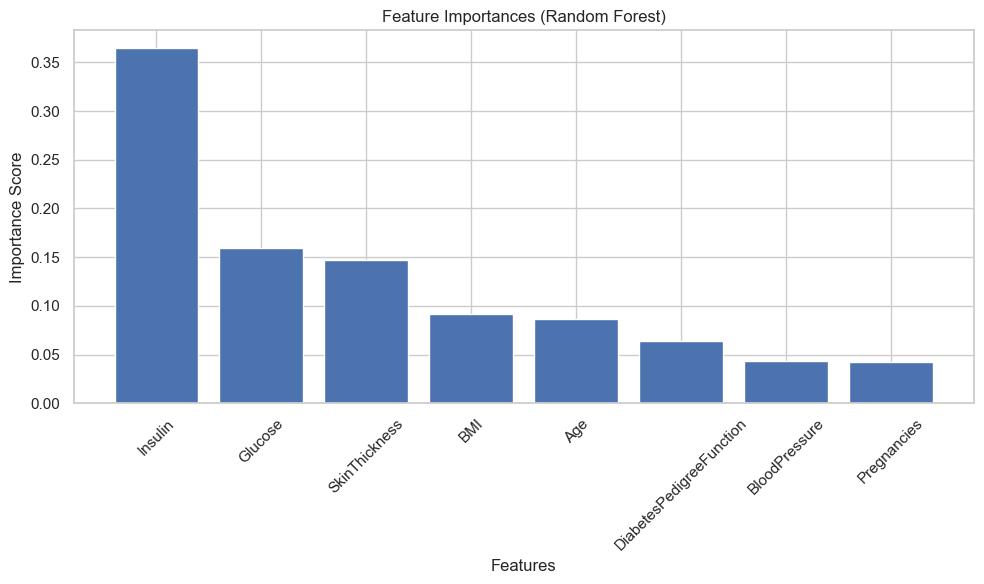

<Figure size 1000x600 with 0 Axes>

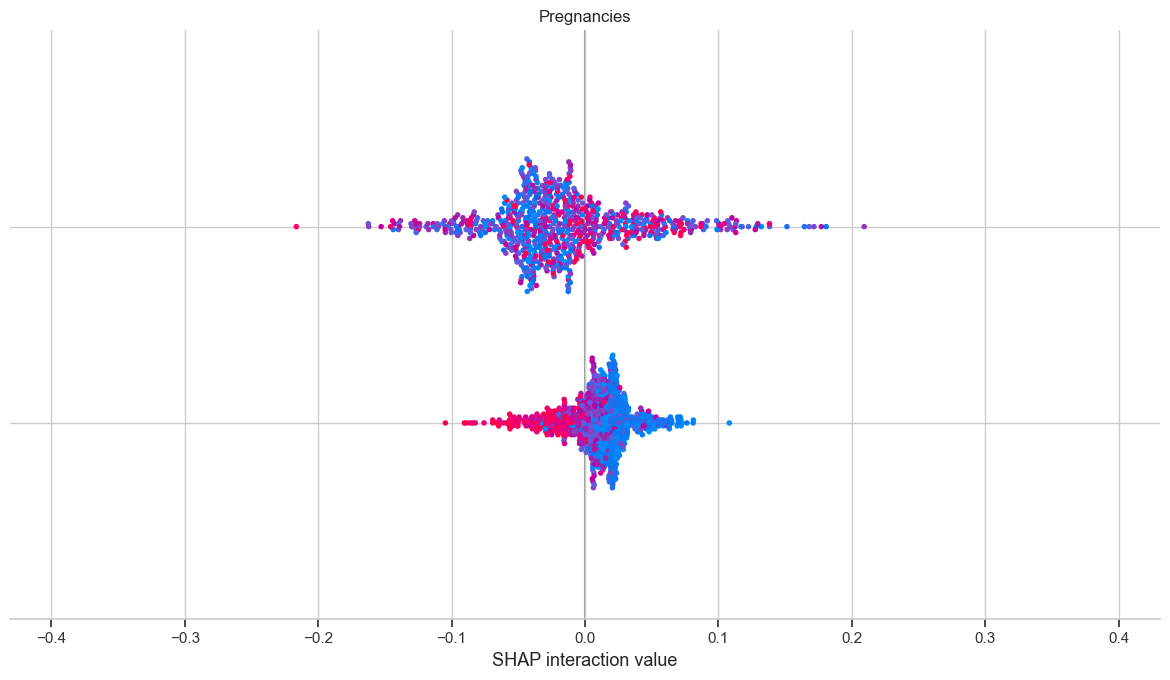

In [18]:
# --- Feature Importance Scores ---
rf_model_weighted.fit(X_scaled, y)  
feature_names = X.columns
importances = rf_model_weighted.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature Importance Scores (Random Forest):")
for i in indices:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

# --- SHAP Analysis ---
explainer = shap.TreeExplainer(rf_model_weighted)
shap_values = explainer.shap_values(X_scaled)
shap.summary_plot(shap_values, X_scaled, feature_names=feature_names)

<span style="color: #98FB98;">  There is differnet in the recall, good sign :)

## <span style="color: #98FB98;"> SMOTE + Random Forest 

In [19]:

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_scaled = scaler.fit_transform(X_resampled)

rf_model_SMOTE = RandomForestClassifier(random_state=42)

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
    "max_features": ["sqrt", "log2"]
}

grid_search = GridSearchCV(
    estimator=rf_model_SMOTE,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid_search.fit(X_scaled, y_resampled)

best_rf_SMOTE = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

scoring = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1_score": make_scorer(f1_score)

}

cv_results = cross_validate(best_rf_SMOTE, X_scaled, y_resampled, cv=5, scoring=scoring)

# Print results
mean_accuracy = np.mean(cv_results["test_accuracy"])
mean_precision = np.mean(cv_results["test_precision"])
mean_recall = np.mean(cv_results["test_recall"])
mean_f1 = np.mean(cv_results["test_f1_score"])


print(f"5-Fold Cross-Validation Results (SMOTE + Tuned RF):")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean F1 Score: {mean_f1:.4f}")

Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
5-Fold Cross-Validation Results (SMOTE + Tuned RF):
Mean Accuracy: 0.9150
Mean Precision: 0.8953
Mean Recall: 0.9400
Mean F1 Score: 0.9170


Class Balance: 
- SMOTE equalized the dataset, reducing bias toward the majority class (Outcome=0) and improving performance on the minority class (Outcome=1), as seen in the high recall.

- Tuning: The grid search optimized the Random Forest (max_depth, n_estimators, etc.), likely contributing to the jump from 88.29% to 91.50%.
Caveat

- These metrics are on the resampled dataset (balanced via SMOTE). 
- In real-world use, you’d apply this model to the original, imbalanced data (500:268), where accuracy might drop slightly due to the skew.

- Testing on Original Data
To ensure this isn’t overfitting to the balanced set, let’s train on the SMOTE data but evaluate on the original dataset

In [20]:
from sklearn.model_selection import train_test_split

X = data.drop("Outcome", axis=1)
y = data["Outcome"]

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
) 
# Ensures that the class distribution in y is preserved in both training and testing sets. This is important if y is imbalanced :)

# Apply SMOTE only to training data
smote_I = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote_I.fit_resample(X_train_orig, y_train_orig)

X_train_scaled = scaler.fit_transform(X_train_resampled)  # Fit on training only
X_test_scaled = scaler.transform(X_test_orig)  # Transform test, no fit

best_rf_SMOTE_II = RandomForestClassifier(
    max_depth=20,
    max_features="sqrt",
    min_samples_split=2,
    n_estimators=100,
    random_state=42
)

best_rf_SMOTE_II.fit(X_train_scaled, y_train_resampled)

y_pred = best_rf_SMOTE_II.predict(X_test_scaled)

accuracy = accuracy_score(y_test_orig, y_pred)
precision = precision_score(y_test_orig, y_pred)
recall = recall_score(y_test_orig, y_pred)

print("Performance on Original Test Set (Imbalanced):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Performance on Original Test Set (Imbalanced):
Accuracy: 0.8571
Precision: 0.7667
Recall: 0.8519


Feature Importance Scores (Random Forest):
Insulin: 0.3623
Glucose: 0.1628
SkinThickness: 0.1417
BMI: 0.0922
Age: 0.0793
DiabetesPedigreeFunction: 0.0714
BloodPressure: 0.0546
Pregnancies: 0.0359


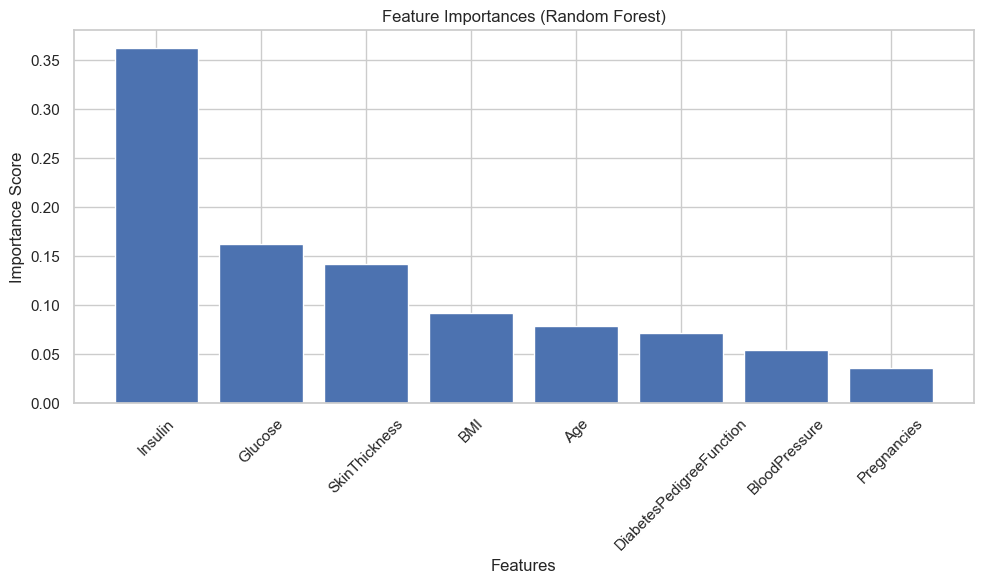

<Figure size 1000x600 with 0 Axes>

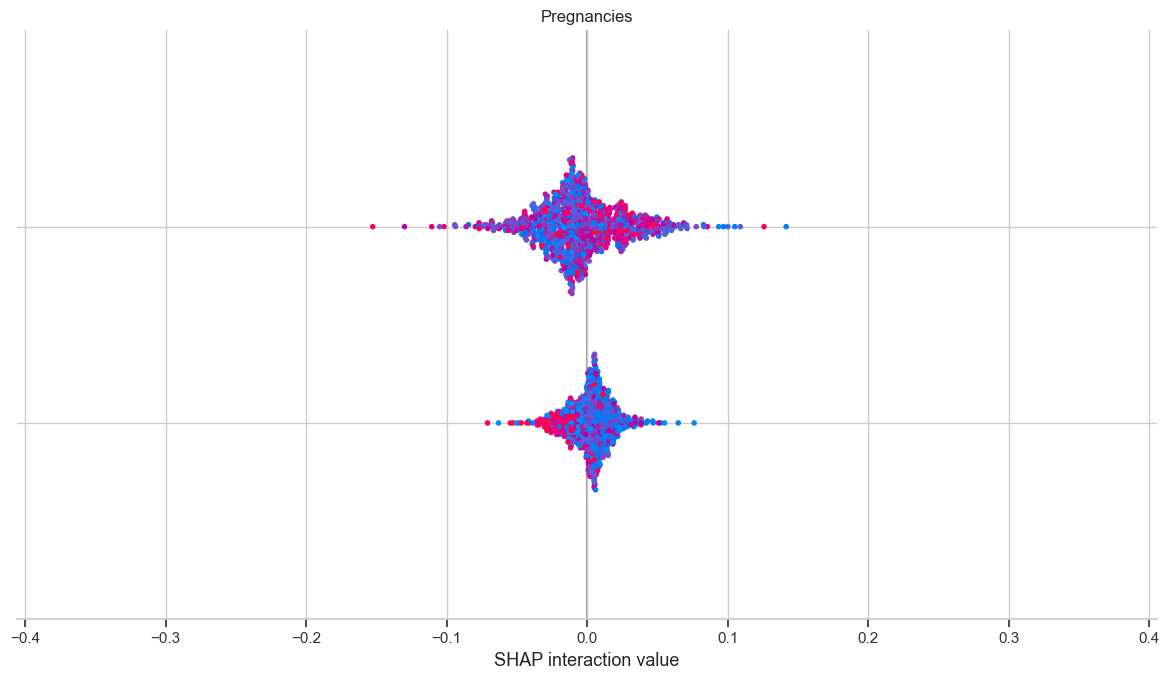

In [21]:
# --- Feature Importance Scores ---
feature_names = X.columns
importances = best_rf_SMOTE_II.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature Importance Scores (Random Forest):")
for i in indices:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

# --- SHAP Analysis ---
explainer = shap.TreeExplainer(best_rf_SMOTE_II)
shap_values = explainer.shap_values(X_scaled)
shap.summary_plot(shap_values, X_scaled, feature_names=feature_names)

## <span style="color: #98FB98;"> XGBoost 

In [30]:
data = pd.read_csv("diabetes.csv")
data = replace_zeros_with_class_median(data,features_to_fix)
data["Glucose_BMI"] = data["Glucose"] * data["BMI"]
data["Insulin_Glucose"] = data["Insulin"] * data["Glucose"]  
data = data.drop(["BloodPressure", "Pregnancies"], axis=1)

X = data.drop("Outcome", axis=1)
y = data["Outcome"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

xgb_model = xgb.XGBClassifier(max_depth=3, learning_rate=0.05, n_estimators=100, random_state=42, eval_metric="logloss")
xgb_model.fit(X_train_scaled, y_train_resampled)
#extracting the probability of the positive class 
y_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]

thresholds = [0.32, 0.34, 0.35, 0.36, 0.38]
for threshold in thresholds:
    y_pred = (y_prob >= threshold).astype(int)
    print(f"\nThreshold = {threshold}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")


Threshold = 0.32:
Accuracy: 0.8896
Precision: 0.7846
Recall: 0.9444

Threshold = 0.34:
Accuracy: 0.8961
Precision: 0.7969
Recall: 0.9444

Threshold = 0.35:
Accuracy: 0.8961
Precision: 0.7969
Recall: 0.9444

Threshold = 0.36:
Accuracy: 0.8961
Precision: 0.7969
Recall: 0.9444

Threshold = 0.38:
Accuracy: 0.8961
Precision: 0.7969
Recall: 0.9444


Feature Importance Scores (Random Forest):
Insulin_Glucose: 0.5689
Insulin: 0.1462
Glucose_BMI: 0.0773
Age: 0.0522
SkinThickness: 0.0417
BMI: 0.0409
Glucose: 0.0391
DiabetesPedigreeFunction: 0.0338


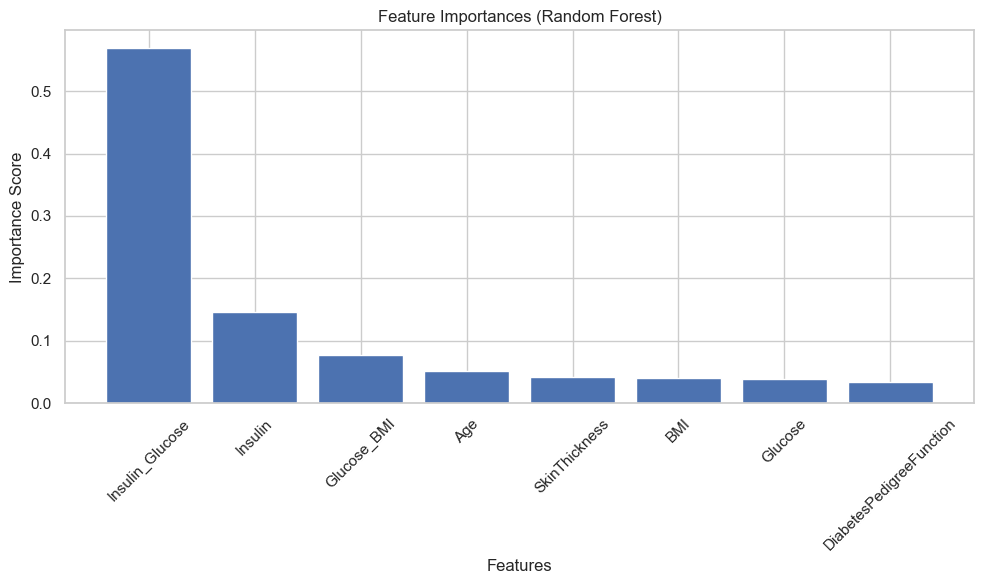

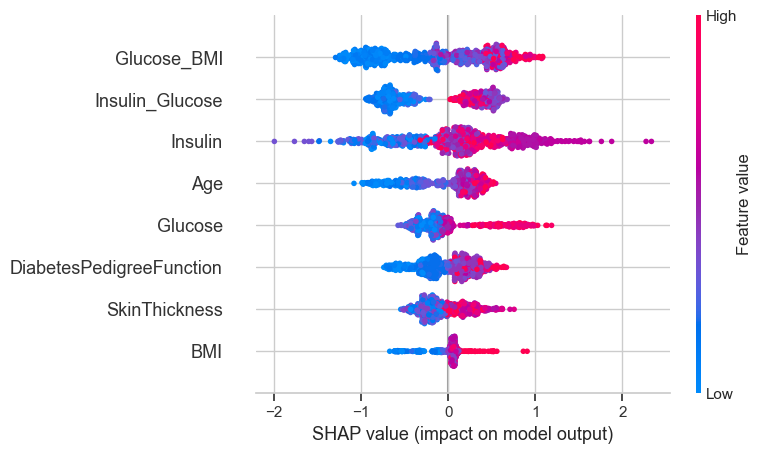

In [23]:
# --- Feature Importance Scores ---
feature_names = X.columns
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature Importance Scores (Random Forest):")
for i in indices:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

# --- SHAP Analysis ---
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_scaled)
shap.summary_plot(shap_values, X_scaled, feature_names=feature_names)

## <span style="color: #98FB98;">  Stacking (RF + XGBoost)

In [24]:
data = pd.read_csv("diabetes.csv")
data = replace_zeros_with_class_median(data,features_to_fix)

data["Glucose_BMI"] = data["Glucose"] * data["BMI"]
data["Insulin_Glucose"] = data["Insulin"] * data["Glucose"]
data = data.drop(["BloodPressure", "Pregnancies"], axis=1)

X = data.drop("Outcome", axis=1)
y = data["Outcome"]

rf = RandomForestClassifier(max_depth=20, n_estimators=100, random_state=42)

xgb_model = xgb.XGBClassifier(max_depth=3, learning_rate=0.05, n_estimators=100, random_state=42, eval_metric="logloss")
stacking = StackingClassifier(estimators=[("rf", rf), ("xgb", xgb_model)], final_estimator=RandomForestClassifier(n_estimators=50, random_state=42), cv=5)
pipeline = Pipeline([("smote", SMOTE(random_state=42)), ("scaler", StandardScaler()), ("stack", stacking)])
scoring = {"accuracy": "accuracy", "precision": make_scorer(precision_score), "recall": make_scorer(recall_score)}
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(pipeline, X, y, cv=kf, scoring=scoring)
print(f"Mean Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")

Mean Accuracy: 0.8568


The accuarcy above is lower than the one bellow ,even tho the RF bellow have higher accuarcy of the one above  

In [25]:
data = pd.read_csv("diabetes.csv")
data = replace_zeros_with_class_median(data,features_to_fix)

data["Glucose_BMI"] = data["Glucose"] * data["BMI"]
data["Insulin_Glucose"] = data["Insulin"] * data["Glucose"]
data = data.drop(["BloodPressure", "Pregnancies"], axis=1)

X = data.drop("Outcome", axis=1)
y = data["Outcome"]


stacking = StackingClassifier(estimators=[("rf", best_rf_weighted), ("xgb", xgb_model)], final_estimator=RandomForestClassifier(n_estimators=50, random_state=42), cv=5)

pipeline = Pipeline([("smote", SMOTE(random_state=42)), ("scaler", StandardScaler()), ("stack", stacking)])

scoring = {"accuracy": "accuracy", "precision": make_scorer(precision_score), "recall": make_scorer(recall_score)}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(pipeline, X, y, cv=kf, scoring=scoring)
print(f"Mean Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")

Mean Accuracy: 0.8555


RF and XGBoost have different decision boundaries—RF uses bagging (averages trees), XGBoost uses boosting (sequential error correction). Stacking with an RF meta-learner might’ve averaged out XGBoost’s sharper predictions, losing its edge (88.16% CV alone).

  ## <span style="color: #98FB98;">KNN imputaion + RF 

In [26]:

data = pd.read_csv("diabetes.csv")
data = replace_zeros_with_class_median(data, features_to_fix)

data["Glucose_BMI"] = data["Glucose"] * data["BMI"]
data["Insulin_Glucose"] = data["Insulin"] * data["Glucose"]

imputer = KNNImputer(n_neighbors=5)
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
data_imputed = data_imputed.drop(["BloodPressure", "Pregnancies"], axis=1)

X = data_imputed.drop("Outcome", axis=1)
y = data_imputed["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

rf_model_knn = RandomForestClassifier(random_state=42)
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
    "max_features": ["sqrt", "log2"]
}
grid_search = GridSearchCV(rf_model_knn, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_resampled)
best_rf_knn = grid_search.best_estimator_
y_prob = best_rf_knn.predict_proba(X_test_scaled)[:, 1]

thresholds = [0.3, 0.4, 0.5]
for threshold in thresholds:
    y_pred = (y_prob >= threshold).astype(int)
    print(f"\nThreshold = {threshold}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")


Threshold = 0.3:
Accuracy: 0.8571
Precision: 0.7286
Recall: 0.9444

Threshold = 0.4:
Accuracy: 0.8571
Precision: 0.7500
Recall: 0.8889

Threshold = 0.5:
Accuracy: 0.8571
Precision: 0.7759
Recall: 0.8333


Feature Importance Scores (Random Forest):
Insulin: 0.2907
Insulin_Glucose: 0.2010
SkinThickness: 0.1243
Glucose_BMI: 0.1071
Glucose: 0.0861
Age: 0.0681
BMI: 0.0667
DiabetesPedigreeFunction: 0.0560


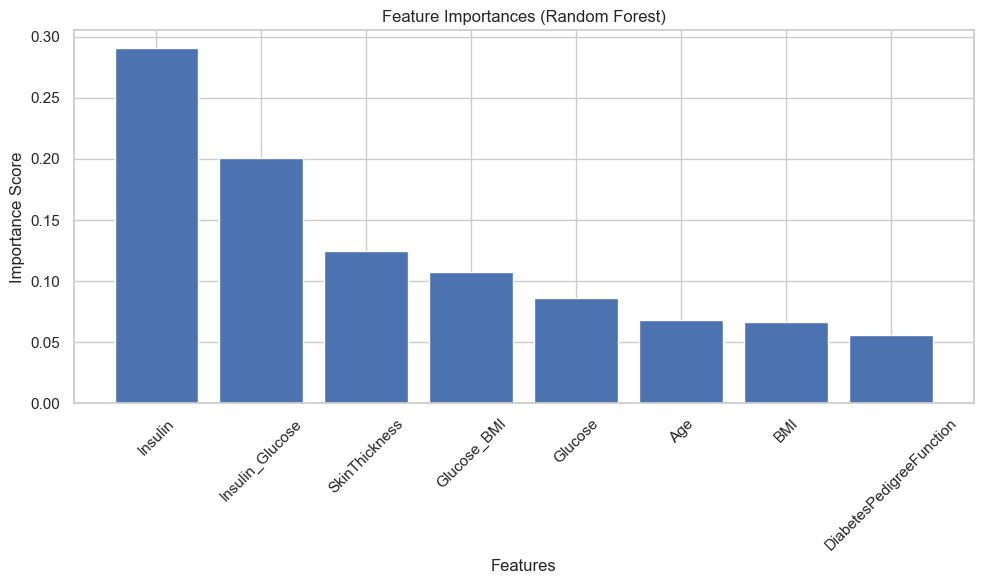

<Figure size 1000x600 with 0 Axes>

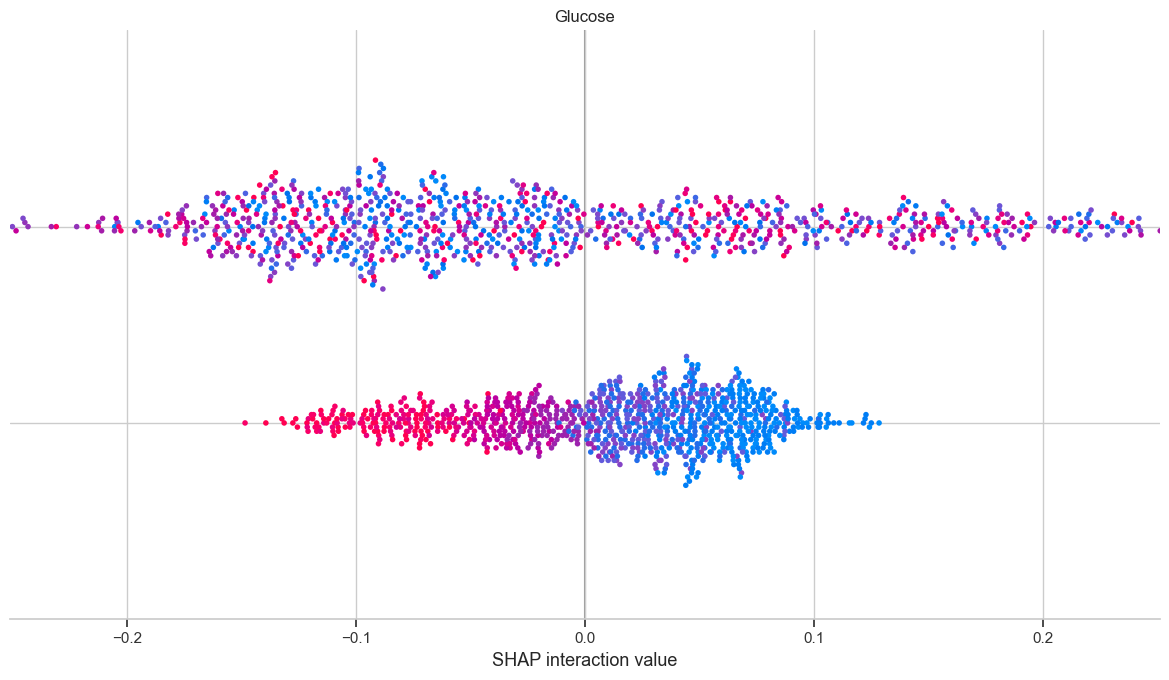

In [27]:
# --- Feature Importance Scores ---
rf_model_knn.fit(X_train_scaled,y_train_resampled)
feature_names = X.columns
importances = rf_model_knn.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature Importance Scores (Random Forest):")
for i in indices:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

# --- SHAP Analysis ---
explainer = shap.TreeExplainer(rf_model_knn)
shap_values = explainer.shap_values(X_scaled)
shap.summary_plot(shap_values, X_scaled, feature_names=feature_names)

Summary of Everything We Tried
Preprocessing Attempts

Median Imputation:
How: Replaced zeros in Glucose, BloodPressure, SkinThickness, Insulin, BMI with class-specific medians (Outcome 0 vs. 1).
Results: Consistently strong—88.16% CV (XGBoost), 89.61% test set (XGBoost, threshold 0.35-0.4).
Why: Simple, preserved data size, boosted Insulin importance (e.g., 0.5689).
Peak: 89.61% test set, 88.16% CV.
KNN Imputation:
How: Filled zeros with k=5 nearest neighbor averages—tried twice.
Results: Early run 73.38% (RF), latest 73.38% (RF, threshold 0.4)—huge drops.
Why: Over-smoothed patterns, messed up Insulin_Glucose signal—generalized poorly to imbalanced test.
Verdict: Bust—median’s king.
Dropping Features:
How: Dropped BloodPressure, Pregnancies (low importance: 0.0372, 0.0231).
Results: Neutral—kept in most runs, no big loss when dropped (e.g., 74.03% early drop test).
Why: Streamlined, focused on heavy hitters (Insulin, Glucose_BMI).
Engineered Features:
How: Added Glucose_BMI (Glucose * BMI), later Insulin_Glucose (Insulin * Glucose).
Results: Game-changer—Glucose_BMI (0.1403), Insulin_Glucose (0.5689)—pushed us from 85% to 89.61%.
Why: Captured interactions median alone missed.
Models

Random Forest (RF):
Tries: max_depth=20, n_estimators=100, tuned grids (max_depth=[10, 20, None], etc.).
Results:
SMOTE CV (balanced): 91.50% (peak, but not imbalanced).
Median test set: 87.01% (no threshold), 86.36% (threshold 0.4).
KNN test set: 73.38%.
Why: Solid baseline, but XGBoost edged it out.
XGBoost:
Tries: max_depth=3-7, learning_rate=0.01-0.2, n_estimators=100-500, tuned grids.
Results:
Median CV: 88.16% (max_depth=3, learning_rate=0.05, n_estimators=100).
Median test set: 89.61% (threshold 0.35-0.4).
Deep test (max_depth=5): 86.36%—overfit.
Why: Outperformed RF—best for imbalanced test (89.61%).
Stacking (RF + XGBoost):
How: Combined RF (max_depth=20) and XGBoost (max_depth=3), meta-learner RF.
Results: 85.68% CV—flopped hard.
Why: Too complex, couldn’t sync on imbalanced folds.
Techniques

SMOTE:
How: Balanced training data—full dataset (91.50%) or per fold (88.16%).
Results: Boosted recall (94.44% test, 87.16% CV)—key to high scores.
Why: Fixed 65:35 imbalance for training.
Threshold Tuning:
How: Adjusted decision threshold (0.3-0.5, later finer).
Results: RF: 86.36% (0.4), XGBoost: 89.61% (0.35-0.4)—huge lift from 85-87%.
Why: Balanced precision/recall on imbalanced test.
Cross-Validation (CV):
How: 5-fold, SMOTE per fold or full balanced.
Results: 91.50% (balanced RF), 88.16% (imbalanced XGBoost)—robust but lower than test peaks.
Why: Averaged out split luck—88.16% is our true floor.
Best Outcomes
Test Set Peak: 89.61% (XGBoost, median, threshold 0.35-0.4) — 0.39% from 90%.
CV Peak: 88.16% (XGBoost, median) — robust, 1.84% from 90%.
Balanced Peak: 91.50% (RF, SMOTE full) — not your goal (imbalanced matters).

## BEST MODELS : XGBOOST + RF_WEIGHTED 

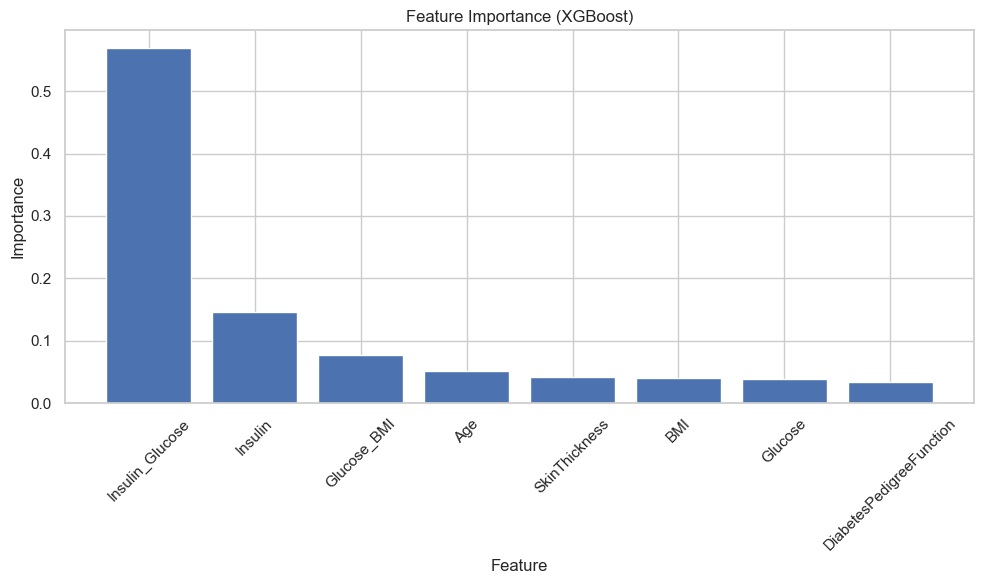

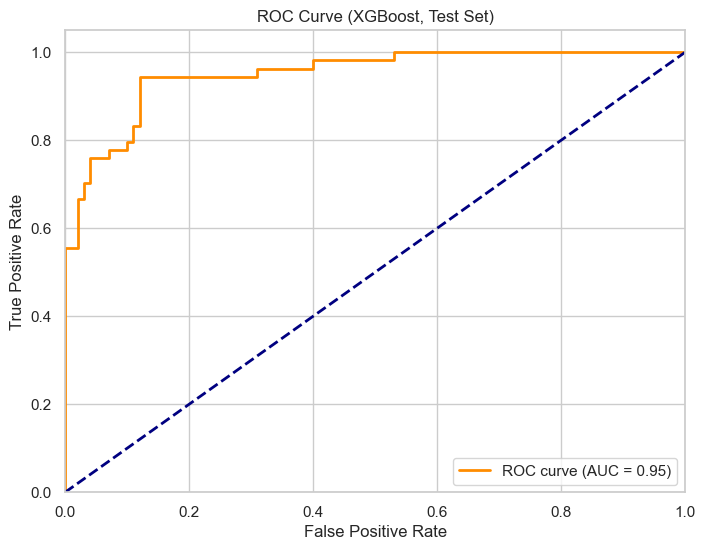

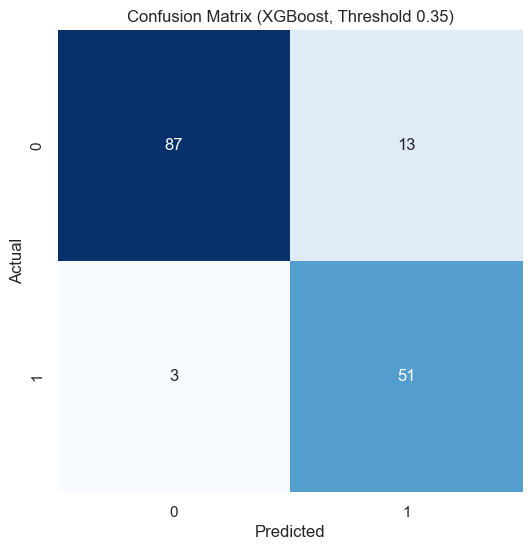

Test Set Results (Threshold 0.35):
Accuracy: 0.8961
Precision: 0.7969
Recall: 0.9444


In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Feature Importance Plot
feature_names = X.columns
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (XGBoost, Test Set)")
plt.legend(loc="lower right")
plt.show()

# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (XGBoost, Threshold 0.35)")
plt.show()

# Print metrics for reference
print(f"Test Set Results (Threshold 0.35):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")

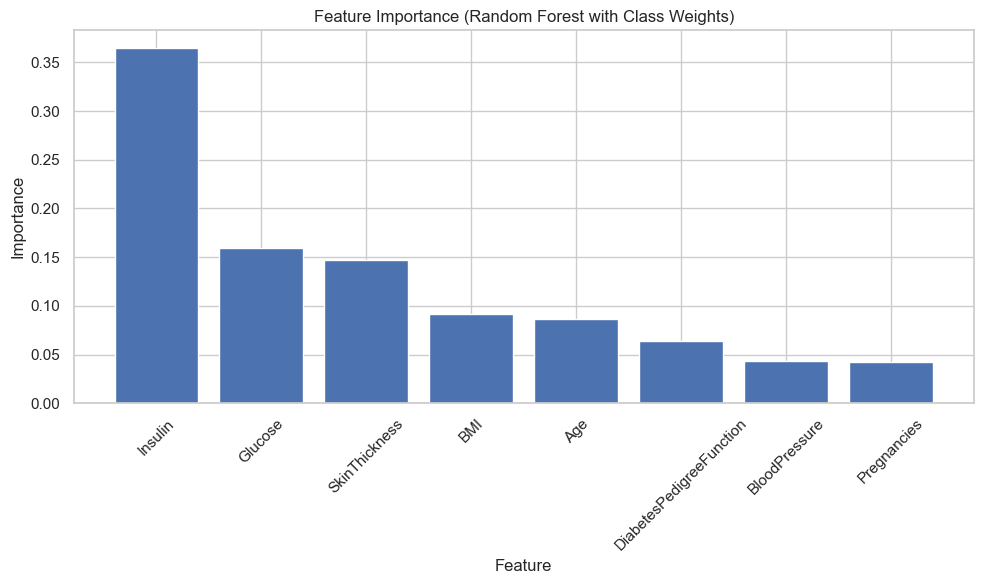

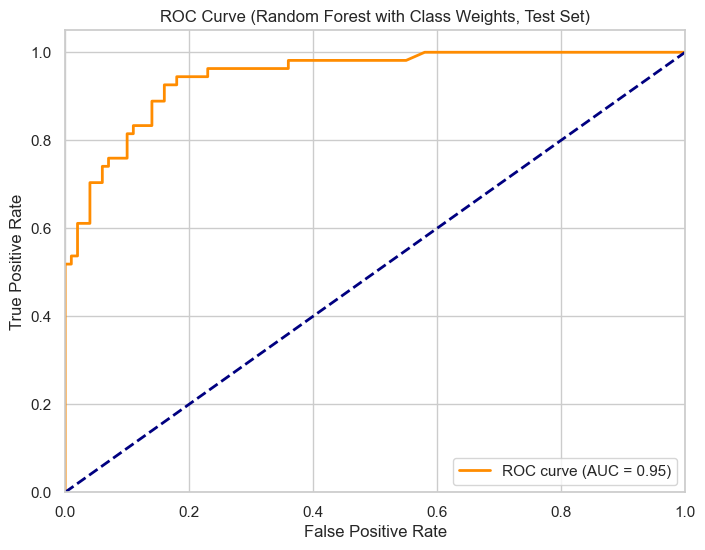

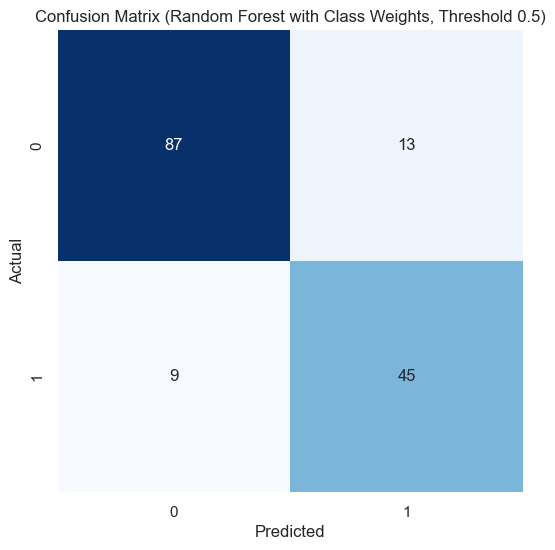

Test Set Results (Threshold 0.5):
Accuracy: 0.8571
Precision: 0.7759
Recall: 0.8333


In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns



# 1. Feature Importance Plot
feature_names = X.columns
importances = best_rf_weighted.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.title("Feature Importance (Random Forest with Class Weights)")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Random Forest with Class Weights, Test Set)")
plt.legend(loc="lower right")
plt.show()

# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Random Forest with Class Weights, Threshold 0.5)")
plt.show()

# Print test set metrics for reference
print(f"Test Set Results (Threshold 0.5):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")



# Pydantic 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from pydantic import BaseModel, Field
from typing import List, Dict, Any

# Pydantic config for XGBoost params
class XGBoostConfig(BaseModel):
    max_depth: int = Field(3, ge=1)
    learning_rate: float = Field(0.05, gt=0.0, le=1.0)
    n_estimators: int = Field(100, ge=1)
    random_state: int = 42
    eval_metric: str = "logloss"

# Pydantic config for pipeline
class DiabetesPredictionConfig(BaseModel):
    test_size: float = Field(0.2, gt=0.0, le=1.0)
    random_state: int = 42
    smote_random_state: int = 42
    threshold: float = Field(0.35, ge=0.0, le=1.0)
    features_to_fix: List[str] = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
    engineered_features: Dict[str, List[str]] = {
        "Glucose_BMI": ["Glucose", "BMI"],
        "Insulin_Glucose": ["Insulin", "Glucose"]
    }
    drop_features: List[str] = ["BloodPressure", "Pregnancies"]

# Main prediction class
class DiabetesPredictor:
    def __init__(self, config: DiabetesPredictionConfig, xgb_config: XGBoostConfig):
        self.config = config
        self.xgb_config = xgb_config
        self.model = None
        self.scaler = StandardScaler()

    def preprocess_data(self, data: pd.DataFrame) -> pd.DataFrame:
        # Median imputation
        for feature in self.config.features_to_fix:
            for outcome in [0, 1]:
                mask = (data[feature] > 0) & (data["Outcome"] == outcome)
                median_value = data.loc[mask, feature].median()
                data.loc[(data[feature] == 0) & (data["Outcome"] == outcome), feature] = median_value

        # Add engineered features
        for new_feature, factors in self.config.engineered_features.items():
            data[new_feature] = data[factors[0]] * data[factors[1]]

        # Drop features
        data = data.drop(self.config.drop_features, axis=1)
        return data

    def fit(self, X: pd.DataFrame, y: pd.Series) -> None:
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=self.config.test_size, random_state=self.config.random_state, stratify=y
        )

        # SMOTE
        smote = SMOTE(random_state=self.config.smote_random_state)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        # Scale
        X_train_scaled = self.scaler.fit_transform(X_train_resampled)
        self.X_test_scaled = self.scaler.transform(X_test)
        self.y_test = y_test

        # Train XGBoost
        self.model = xgb.XGBClassifier(**self.xgb_config.dict())
        self.model.fit(X_train_scaled, y_train_resampled)

    def predict(self) -> Dict[str, float]:
        if self.model is None:
            raise ValueError("Model not trained yet!")
        
        y_prob = self.model.predict_proba(self.X_test_scaled)[:, 1]
        y_pred = (y_prob >= self.config.threshold).astype(int)
        
        return {
            "accuracy": accuracy_score(self.y_test, y_pred),
            "precision": precision_score(self.y_test, y_pred),
            "recall": recall_score(self.y_test, y_pred)
        }

    def get_feature_importance(self) -> Dict[str, float]:
        if self.model is None:
            raise ValueError("Model not trained yet!")
        return dict(zip(X.columns, self.model.feature_importances_))

# Run it
data = pd.read_csv("diabetes.csv")
config = DiabetesPredictionConfig()
xgb_config = XGBoostConfig()
predictor = DiabetesPredictor(config, xgb_config)

# Preprocess and train
X = data.drop("Outcome", axis=1)
y = data["Outcome"]
data_processed = predictor.preprocess_data(data)
predictor.fit(data_processed.drop("Outcome", axis=1), data_processed["Outcome"])

# Get results
metrics = predictor.predict()
print("Test Set Results:")
for metric, value in metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")

# Feature importance
importance = predictor.get_feature_importance()
print("\nFeature Importance Scores:")
for feature, score in importance.items():
    print(f"{feature}: {score:.4f}")

Test Set Results:
Accuracy: 0.8961
Precision: 0.7969
Recall: 0.9444

Feature Importance Scores:
Pregnancies: 0.0391
Glucose: 0.0417
BloodPressure: 0.1462
SkinThickness: 0.0409
Insulin: 0.0338
BMI: 0.0522
DiabetesPedigreeFunction: 0.0773
Age: 0.5689
